# Discrete Dynamical Systems with Julia!

Dynamical systems are rules describing the evolution of some variable $\vec{u}$ in time, according to some equations of motion given by a function $\vec{f}$.  
Here, we'll investigate _discrete dynamical systems_, often called _maps_, whereby time is discrete (in 'time-steps') and the equations of motion take the general form:

$$
\vec{u}_{n+1} = \vec{f}(\vec{u}_n,p,n)
$$

We'll start by using a performant julia library to achieve this, and then try to match that behavior ourselves using minimal julia code (adapted from Chris Rackauckas's [Parallel Computing and Scientific Machine Learning](https://github.com/mitmath/18337) course notes).

## DynamicalSystems.jl

[DynamicalSystems.jl](https://juliadynamics.github.io/DynamicalSystems.jl/latest/) is a performant Julia software library for dynamical systems, deterministic chaos and nonlinear timeseries analysis.  

We start by importing the necessary packages

In [ ]:
using DynamicalSystems, Plots, StaticArrays, BenchmarkTools

### De Jong attractor
Let's have a look at the following attractor:
$$
\begin{align}
x_{n+1} &= sin(a y_n) - cos(b x_n) \\
y_{n+1} &= sin(c x_n) - cos(d y_n)
\end{align}
$$

we define a function to perform this map:

In [195]:
function dejong_eom(x,p,t)
    a,b,c,d = p
    dx = sin(a*x[2]) - cos(b*x[1])
    dy = sin(c*x[1]) - cos(d*x[2])
    @SVector [dx, dy]
end

dejong_eom (generic function with 1 method)

Next, we need an initial state to start our iteration:

In [196]:
initial_state = @SVector([1.0 ,1.0]);

and finally, our parameters, $p$:

In [197]:
p = [-2.0,-2.0,-1.2,2.0];

now, we can define our `DynamicalSystem`:

In [198]:
dejong = DiscreteDynamicalSystem(dejong_eom,initial_state,p)

2-dimensional discrete dynamical system
 state:       [1.0, 1.0]
 e.o.m.:      dejong_eom
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [-2.0, -2.0, -1.2, 2.0]

obtaining a trajectory for some 100000 points is then straightforward:

In [199]:
trajectory_dejong = trajectory(dejong,100000)

2-dimensional Dataset{Float64} with 100001 points
  1.0         1.0
 -0.493151   -0.515892
  0.306438    0.0445516
 -0.906983   -1.35553
  0.65814     1.79462
  0.181063    0.19128
 -1.30844    -1.14328
  1.62006     1.6562
  1.16512     0.0543114
  0.580111   -1.97924
 -1.12815     0.0432392
  0.546698   -0.019718
 -0.420047   -1.6092
  ⋮          
 -0.209629   -0.449872
 -0.130223   -0.3729
 -0.287716   -0.578913
  0.0769755  -0.062891
 -0.862722   -1.08434
  0.980563    1.42289
  0.0889784   0.0332322
 -1.05062    -1.10436
  1.30925     1.54785
  0.820409   -0.00105257
  0.0720691  -1.83299
 -1.49031     0.779258

We can plot the trajectory to visualize our attractor:

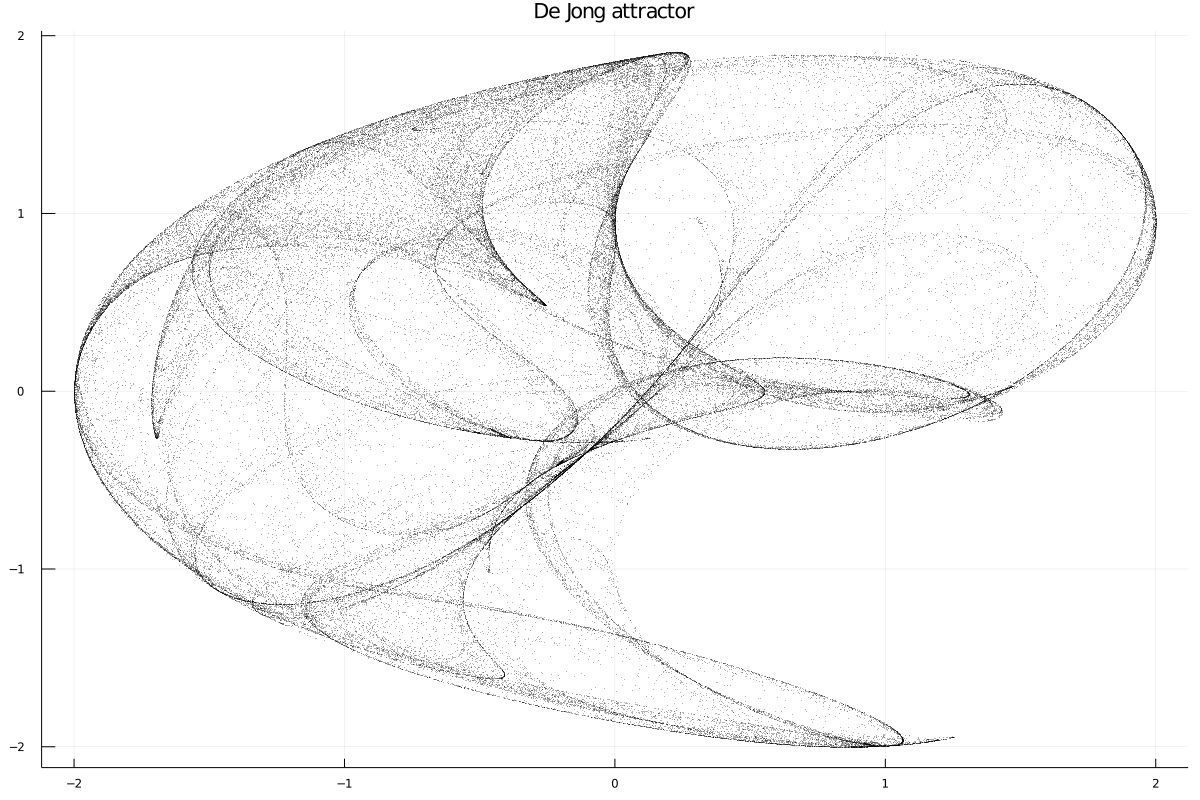

In [200]:
scatter(trajectory_dejong[:,1], trajectory_dejong[:,2], 
    markersize=0.1, markeralpha = 0.3, markercolor="black",
    leg=false, title="De Jong attractor", 
    html_output_format=:png, size=(1200,800))

#### Performance
Let's evaluate the performance of the above code. We'll use the `BenchmarkTools` package:

In [201]:
@btime trajectory(dejong,10000);

  363.753 μs (3 allocations: 156.41 KiB)


This is indeed quite fast, let's see if we can match this using our own implementation.

## Minimal Implementation of Discrete Dynamical Systems
We'll follow the same paradigm as `DynamicalSystems.jl` to code this efficiently. Namely, we'll define a _higher order function_ which will accept our equations of motion as an argument and type-specialize on that function during compilation

In [202]:
# Higher order function
function solve_discrete_map(f,u0,p,n)
    # Set initial state
    u = u0
    for i in 1:n-1
        # Iteratively apply map n times
        u = f(u,p)
    end
    # Return final result
    u
end

solve_discrete_map (generic function with 1 method)

In [203]:
function dejong_eom_naive(u,p)
    a,b,c,d = p
    du1 = sin(a*u[2]) - cos(b*u[1])
    du2 = sin(c*u[1]) - cos(d*u[2])
    [du1, du2]
end

initial_state = [1.0, 1.0];
p = (-2.0,-2.0,-1.2,2.0);

@btime solve_discrete_map(dejong_eom_naive, initial_state, p , 10000)

  406.450 μs (9999 allocations: 937.41 KiB)


2-element Array{Float64,1}:
 -0.7008251708553968
  0.7367524522538722

This is already quite fast!  
But, we're making a lot of costly allocations. Also, note this only returns the final point - not the whole trajectory.  
Let's use statically-sized arrays to save the entire trajectory:

In [204]:
function solve_discrete_map_save(f,u0,p,n)
    # Set statically-sized output array
    u = Vector{typeof(u0)}(undef,n)
    u[1] = u0
    for i in 1:n-1
        u[i+1] = f(u[i],p)
    end
    u
end

@btime solve_discrete_map_save(dejong_eom_naive, initial_state, p , 10000)

  417.672 μs (10001 allocations: 1015.61 KiB)


10000-element Array{Array{Float64,1},1}:
 [1.0, 1.0]
 [-0.4931505902785393, -0.5158922494200839]
 [0.30643790803277227, 0.04455162600844187]
 [-0.9069825638734501, -1.3555268411543053]
 [0.658140052846526, 1.7946170329610385]
 [0.18106329875550853, 0.1912804953483983]
 [-1.3084431144108262, -1.1432820988891732]
 [1.6200606371145652, 1.656196816705814]
 [1.1651217092057897, 0.054311406123015216]
 [0.5801112389212997, -1.9792392668541616]
 [-1.1281533204536758, 0.043239164748129055]
 [0.546697544346086, -0.01971799070569602]
 [-0.42004676977911304, -1.6092038509730124]
 ⋮
 [-0.6355452247716361, -1.0085264709158335]
 [0.6068298253565421, 1.1224347006287676]
 [-1.1308788660381157, -0.04135070838793675]
 [0.719885543875078, -0.019338108102586404]
 [-0.09198408765486893, -1.7596092107903445]
 [-1.3518400886702822, 1.0396995644672267]
 [0.032213114221819716, 1.4856360795515366]
 [-1.16742356316133, 0.9468843834892449]
 [-0.2564442455292393, 1.302990412829968]
 [-1.381698053521903, 1.162855537

We now obtain the full trajectory! It seems natural to use matrices instead, since our data is a full 2D array.

In [205]:
function solve_discrete_map_save_matrix(f,u0,p,n)
    # Set statically-sized output array
    u = Matrix{eltype(u0)}(undef,length(u0),n)
    u[:,1] = u0
    for i in 1:n-1
        u[:,i+1] = f(u[:,i],p)
    end
    u
end

@btime solve_discrete_map_save_matrix(dejong_eom_naive, initial_state, p , 10000)

  708.364 μs (20000 allocations: 1.98 MiB)


2×10000 Array{Float64,2}:
 1.0  -0.493151  0.306438   -0.906983  …  -1.3817   0.201002  -0.700825
 1.0  -0.515892  0.0445516  -1.35553       1.16286  1.68142    0.736752

What went wrong? this is almost twice as slow with twice as many allocations!  
The problem is that slicing automatically makes a copy of the array in julia. To remedy this, we can use the `@view` macro.

In [206]:
function solve_discrete_map_save_matrix(f,u0,p,n)
    # Set statically-sized output array
    u = Matrix{eltype(u0)}(undef,length(u0),n)
    u[:,1] = u0
    for i in 1:n-1
        u[:,i+1] = f(@view(u[:,i]),p)
    end
    u
end

@btime solve_discrete_map_save_matrix(dejong_eom_naive, initial_state, p , 10000)

  474.317 μs (10001 allocations: 1.07 MiB)


2×10000 Array{Float64,2}:
 1.0  -0.493151  0.306438   -0.906983  …  -1.3817   0.201002  -0.700825
 1.0  -0.515892  0.0445516  -1.35553       1.16286  1.68142    0.736752

Notice we used `StaticArrays` in the beginning with `DynamicalSystems`. Indeed, we can leverage the same functionality since our map is only two-dimensional:

In [207]:
function dejong_eom_static(u,p)
    a,b,c,d = p
    du1 = sin(a*u[2]) - cos(b*u[1])
    du2 = sin(c*u[1]) - cos(d*u[2])
    @SVector [du1, du2]
end

@btime solve_discrete_map_save(dejong_eom_static,@SVector[1.0,1.0], p , 10000);

  260.297 μs (2 allocations: 156.33 KiB)


This is in-fact faster than the `DynamicalSystems` evaluation!  
Going further, since we know we're always accessing a 2D array, we can turn off bounds checks.

In [208]:
function dejong_eom_fast(u,p)
    a,b,c,d = p
    @inbounds begin
    du1 = sin(a*u[2]) - cos(b*u[1])
    du2 = sin(c*u[1]) - cos(d*u[2])
    end
    @SVector [du1, du2]
end

function solve_discrete_map_fast(f,u0,p,n)
    u = Vector{typeof(u0)}(undef,n)
    @inbounds u[1] = u0
    @inbounds for i in 1:n-1
        u[i+1] = f(u[i],p)
    end
    u
end

@btime solve_discrete_map_fast(dejong_eom_fast,@SVector[1.0,1.0], p , 10000);

  254.979 μs (2 allocations: 156.33 KiB)


Finally, we can eliminate all allocations by using an in-place function:

In [209]:
function solve_discrete_map_fast!(u,f,u0,p,n)
    @inbounds u[1] = u0
    @inbounds for i in 1:length(u)-1
        u[i+1] = f(u[i],p)
    end
    u
end

u = Vector{typeof(@SVector[1.0,1.0])}(undef,10000)
@btime solve_discrete_map_fast!(u,dejong_eom_fast,@SVector[1.0,1.0], p , 10000);

  253.822 μs (0 allocations: 0 bytes)


### Binning along the way
Notice we've made the iteration loop very fast, but plotting all these points will still be slow. Instead, we can count the number of hits, binning along the way.  
First, let's write a mutating version of our attractor:

In [210]:
function dejong_eom_fast_ip(du,u,p)
    a,b,c,d = p
    @inbounds begin
    du[1] = sin(a*u[2]) - cos(b*u[1])
    du[2] = sin(c*u[1]) - cos(d*u[2])
    end
end

function solve_discrete_map_mutate(f,u0,p,n)
    du = similar(u0)
    u  = copy(u0)
    for i in 1:n-1
        f(du,u,p)
        u,du = du,u
    end
    u
end

@btime solve_discrete_map_mutate(dejong_eom_fast_ip,[1.0,1.0], p , 10000)

  265.470 μs (3 allocations: 288 bytes)


2-element Array{Float64,1}:
 -0.7008251708553968
  0.7367524522538722

Finally, let's add in-place binning logic:

In [211]:
function solve_discrete_map_mutate!(bins,f,u0,p,n,op)
    
    xmin,xmax,ymin,ymax,delta = op
    dimx, dimy = size(bins)
    
    du = similar(u0)
    u  = copy(u0)
    
    @inbounds for i in 1:n-1
        f(du,u,p)
        u,du = du,u
        
        tx = floor(Int,(u[1]-xmin)/delta) +1
        ty = floor(Int,(u[2]-ymin)/delta) +1
        if tx >= 1 && tx <= dimx && ty >= 1 && ty <= dimy
            bins[tx,ty] +=1
        end
        
    end
end

solve_discrete_map_mutate! (generic function with 1 method)

In [212]:
xmin,xmax,ymin,ymax,delta = (-2.5,2.5,-2.5,2.5,0.005)
dimx = floor(Int,(xmax -xmin)/delta) +1
dimy = floor(Int,(ymax -ymin)/delta) +1
bins = zeros(Int,dimx,dimy);

@btime solve_discrete_map_mutate!(bins,dejong_eom_fast_ip,[1.0,1.0], p , 10000,(xmin,xmax,ymin,ymax,delta))

  318.483 μs (4 allocations: 336 bytes)


In [213]:
bins = zeros(Int,dimx,dimy);
@btime solve_discrete_map_mutate!(bins,dejong_eom_fast_ip,[1.0,1.0], p , 10000000,(xmin,xmax,ymin,ymax,delta))

  358.282 ms (4 allocations: 336 bytes)


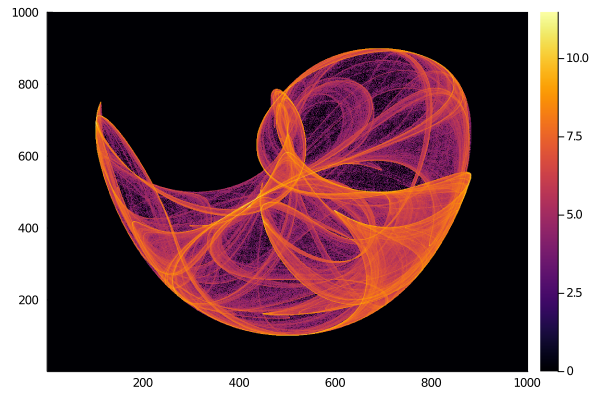

In [214]:
heatmap(log.(bins.+1))